In [1]:
import torch
torch.manual_seed(43438)
from torch.utils.data import Dataset, DataLoader
from evaluate import evaluate
from model_utils import load_checkpoint
import net
from data_loader import *
import torch.optim as optim
import torch.nn as nn
import os
import cv2
import sys
sys.path.append("../")
from utils import adjustColor, plot_histogram_normalized
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
model = net.Net().cuda()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 1e-4)
loss_fn = nn.L1Loss()

In [3]:
restore_path = os.path.join('ckpt/0922_00_06', 'best.pth.tar')
model, optimizer, start_epoch, best_val_loss = load_checkpoint(restore_path, model, optimizer)

[*] Loaded model from ckpt/0922_00_06/best.pth.tar


In [4]:
eval_transformer =  GroupComposed([
    GroupToPILImage(mode = 'L'),
    GroupRandomCrop(2048), ## random crop may cause broken Bayer pattern
    GroupToTensor()
])
dataloader = DataLoader(HDRDataset(eval_transformer, 1),
                            batch_size = 1, shuffle = True,
                            num_workers = int(8),
                            pin_memory=True)

cuda=True
model.eval()

with torch.no_grad():
    for i, (val_batch, labels_batch) in enumerate(dataloader):
        n_seq = val_batch.size(1)
        output_batch = val_batch[:, 0:1].clone()
        if cuda:
            output_batch = output_batch.cuda(non_blocking=True)
        for j in range(1, n_seq):
            print("processing {}th image....".format(j))
            input_batch = torch.cat([val_batch[:, 0:1], val_batch[:, j:j+1]], dim = 1)
            if cuda:
                input_batch, labels_batch = input_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)
            res = model(input_batch)
#                 output_batch = res
            output_batch += res.clone()
#             #########
#             output_batch = torch.sigmoid(output_batch)
        output_batch = output_batch/float(n_seq)

processing 1th image....
processing 2th image....
processing 3th image....
processing 4th image....
processing 5th image....
processing 6th image....
processing 7th image....


In [5]:
output_batch.size()

torch.Size([1, 1, 2048, 2048])

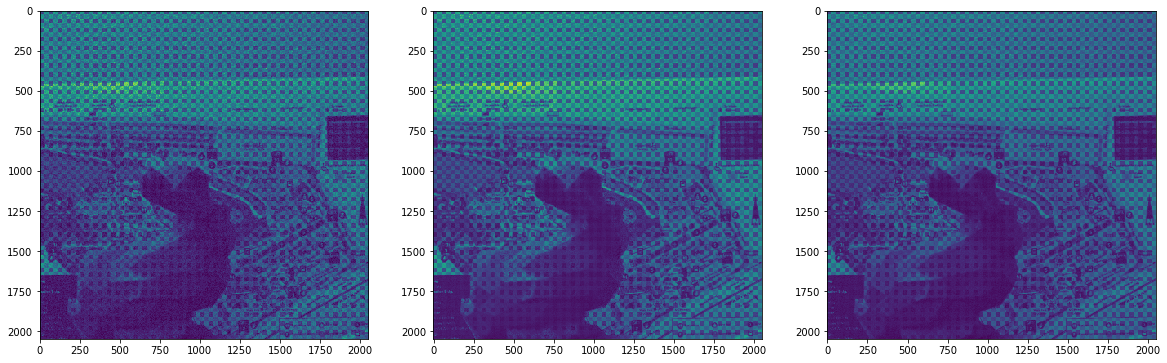

In [6]:
ref = val_batch[0, 0].numpy()
avg = np.mean(val_batch[0, :].numpy(), axis = 0)
output = output_batch[0, 0].detach().cpu().numpy()
gt = labels_batch[0, 0].cpu().numpy()
fig, ax = plt.subplots(1, 3, figsize=(20, 16))
ax[0].imshow(ref)
ax[1].imshow(output)
ax[2].imshow(gt)
plt.show()

## Ground Truth

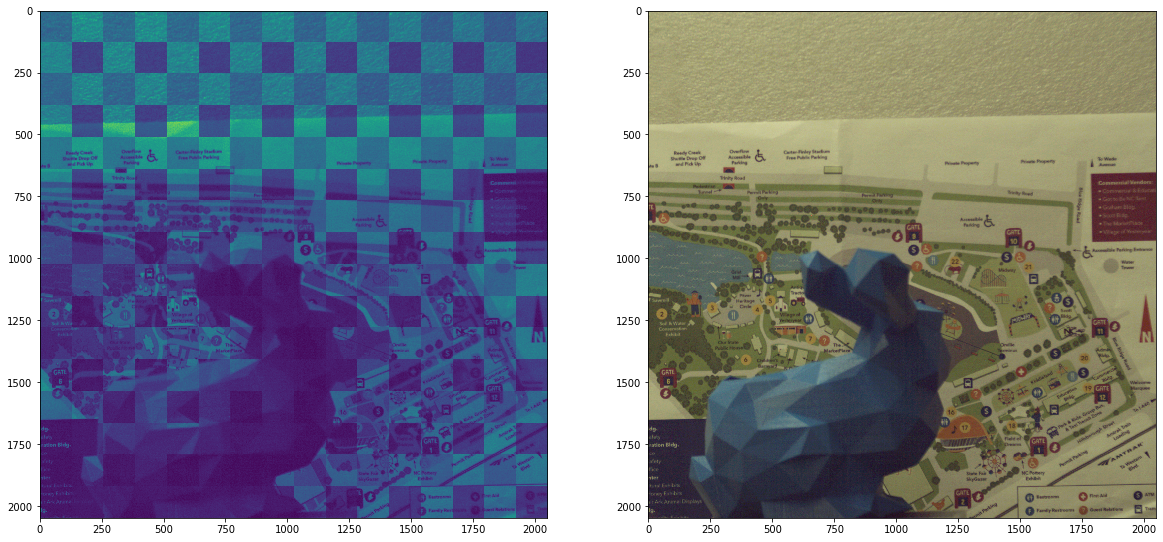

In [7]:
# rgb_gt = demosaic(gt)
rgb_gt = cv2.cvtColor((gt*255.0).astype(np.uint8), cv2.COLOR_BAYER_BG2RGB)
rgb_gt = adjustColor(rgb_gt,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(gt)
ax[1].imshow(rgb_gt)
plt.show()

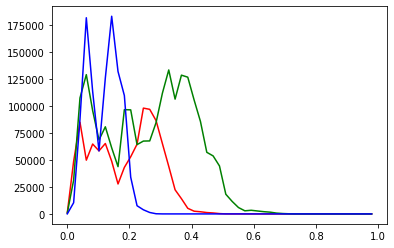

In [14]:
plot_histogram_normalized(gt)

## prediction

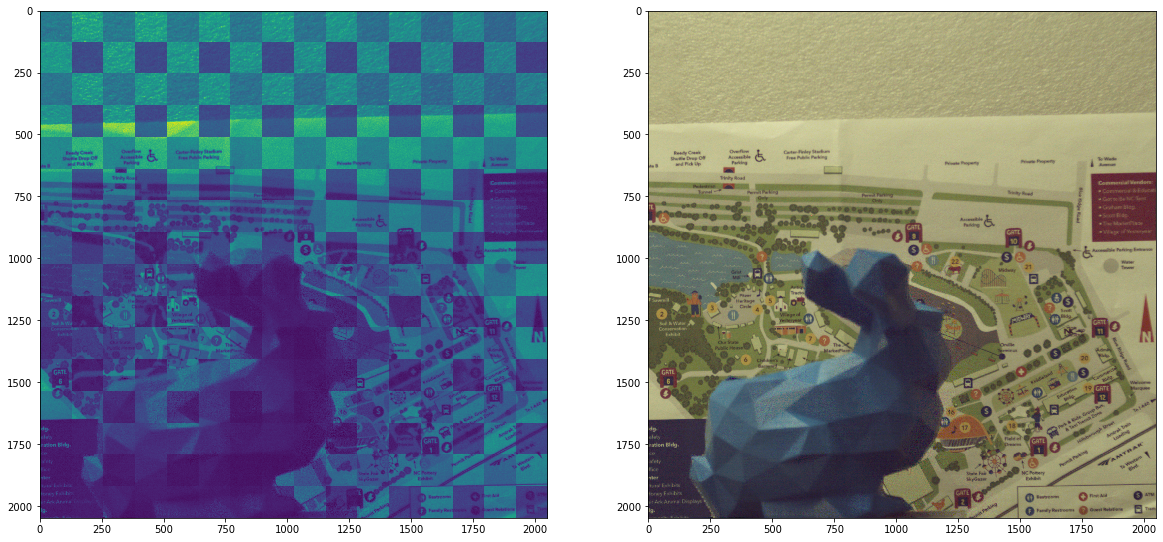

In [8]:
rgb_output = cv2.cvtColor((output*255.0).astype(np.uint8), cv2.COLOR_BAYER_BG2RGB)
rgb_output = adjustColor(rgb_output,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(output)
ax[1].imshow(rgb_output)
plt.show()

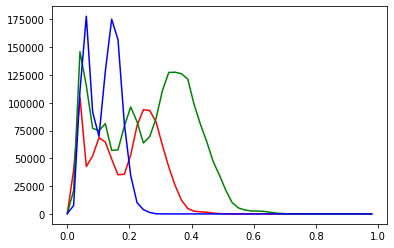

In [15]:
plot_histogram_normalized(output)

## 8 frames average

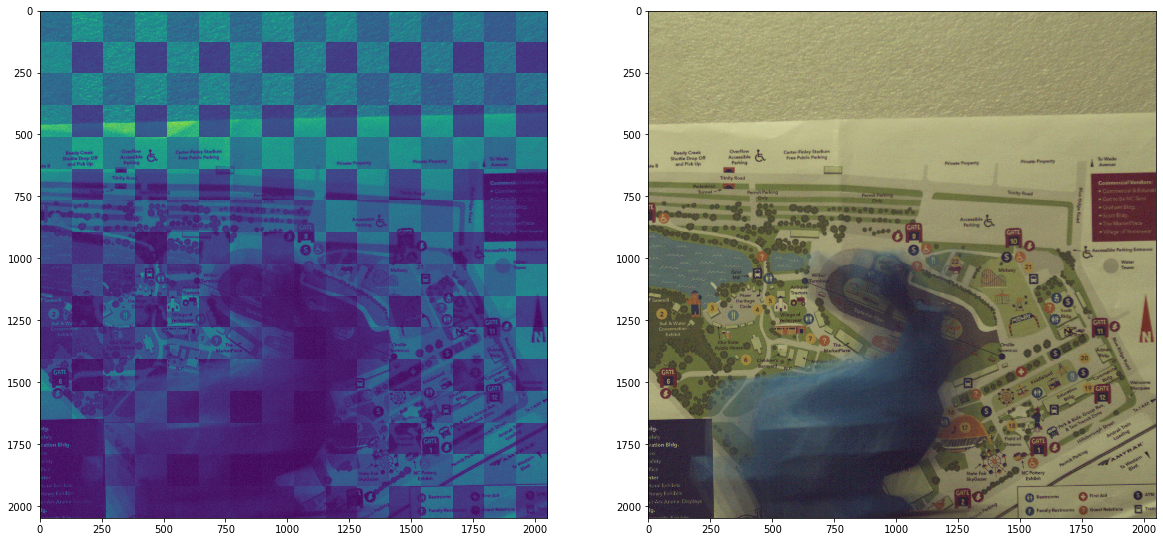

In [9]:
rgb_avg = cv2.cvtColor((avg*255.0).astype(np.uint8), cv2.COLOR_BAYER_BG2RGB)
rgb_avg = adjustColor(rgb_avg,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(avg)
ax[1].imshow(rgb_avg)
plt.show()

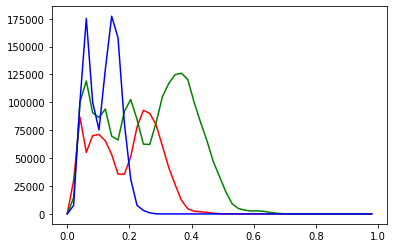

In [13]:
plot_histogram_normalized(avg)

## single frame

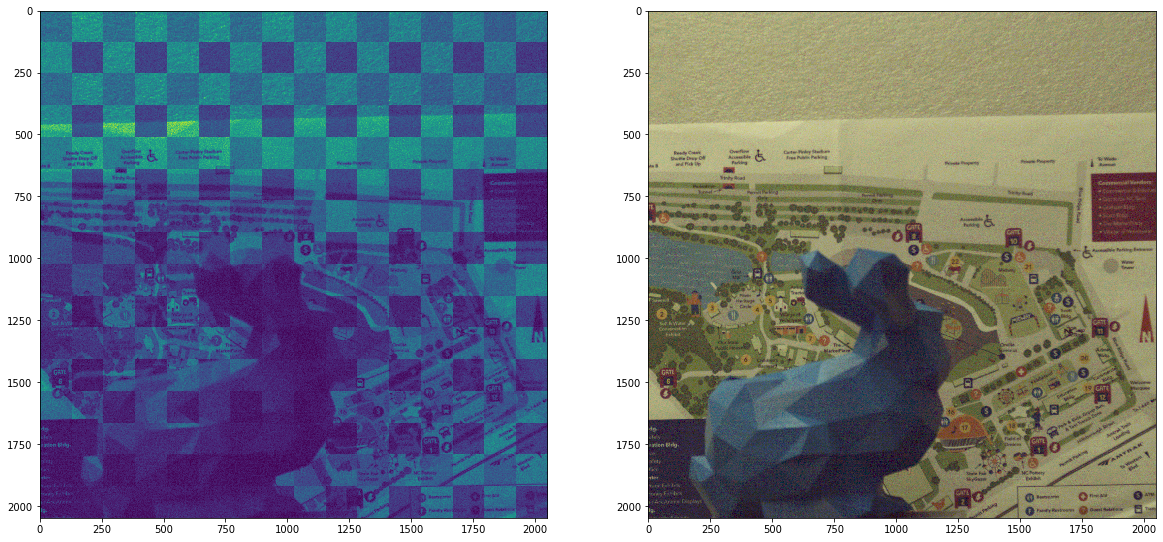

In [10]:
rgb_ref = cv2.cvtColor((ref*255.0).astype(np.uint8), cv2.COLOR_BAYER_BG2RGB)
rgb_ref = adjustColor(rgb_ref,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(ref)
ax[1].imshow(rgb_ref)
plt.show()

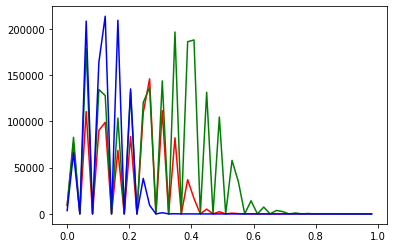

In [12]:
plot_histogram_normalized(ref)

## comparison

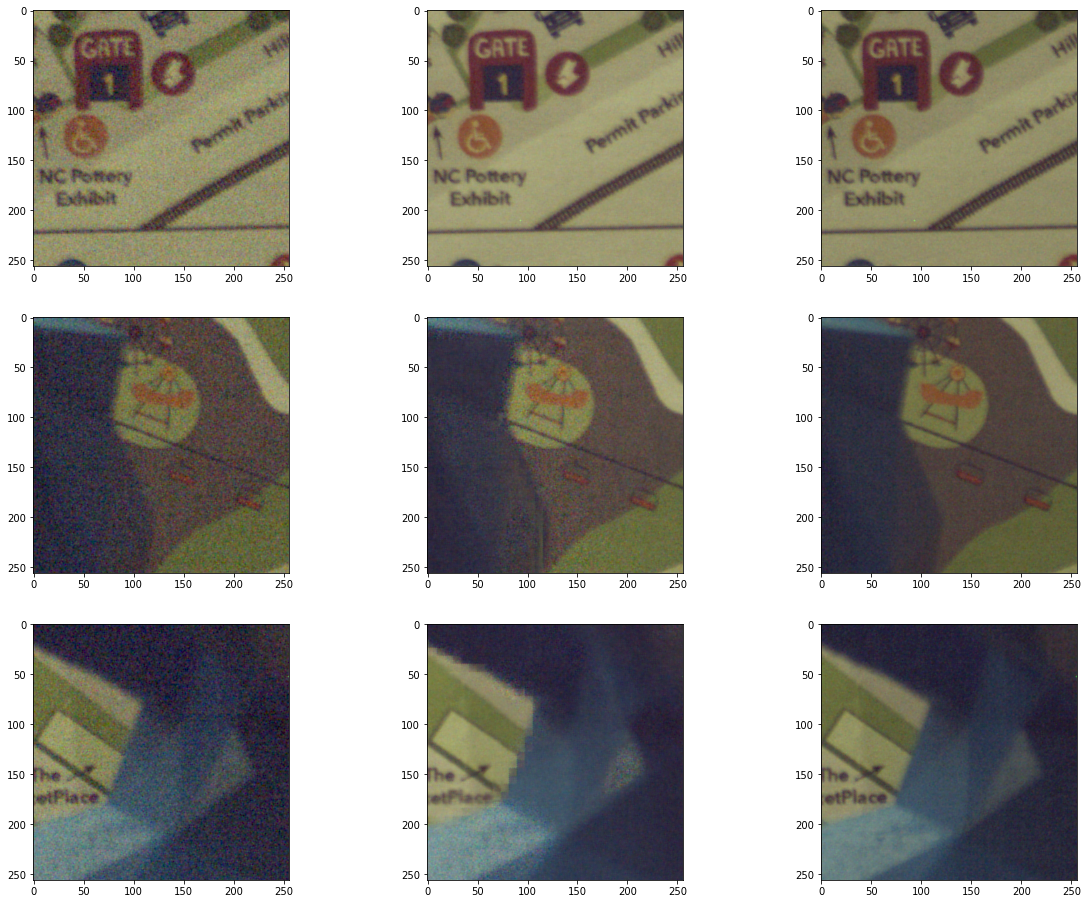

In [21]:
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
ax[0][0].imshow(rgb_ref[1700:1700+256, 1500:1500+256])
ax[0][1].imshow(rgb_output[1700:1700+256, 1500:1500+256])
ax[0][2].imshow(rgb_gt[1700:1700+256, 1500:1500+256])
ax[1][0].imshow(rgb_ref[1200:1200+256, 1100:1100+256])
ax[1][1].imshow(rgb_output[1200:1200+256, 1100:1100+256])
ax[1][2].imshow(rgb_gt[1200:1200+256, 1100:1100+256])
ax[2][0].imshow(rgb_ref[1200:1200+256, 750:750+256])
ax[2][1].imshow(rgb_output[1200:1200+256, 750:750+256])
ax[2][2].imshow(rgb_gt[1200:1200+256, 750:750+256])
plt.show()